## Description:

This file contains:
* Using saved model file:
    * predict on unseen 600k non-sub fvids
    * eda on their behavior

In [1]:
"""Helper"""
import pandas as pd
import numpy as np
import time
import joblib
from joblib import parallel_backend

"""Visualization"""
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

'''Modeling'''
import lightgbm as lgb

'''GCS Utils'''
from gcs_utils import *

'''Modeling Helpers'''
from sklearn.metrics import (f1_score, 
                             auc, 
                             classification_report, 
                             accuracy_score, 
                             confusion_matrix, 
                             plot_confusion_matrix, 
                             precision_recall_curve, 
                             recall_score,
                             precision_score,
                             roc_curve, 
                             roc_auc_score)

SEED = 42

* **Read serialized objects**

In [2]:
# load model
lgbm_model = joblib.load("chk_lgbm_model.joblib")
print(lgbm_model)

# load serialized objects
feat_selected = joblib.load("chk_feat_selected.joblib")
print(len(feat_selected))

scaler = joblib.load("chk_scaler.joblib")

LGBMClassifier(random_state=42)
59


FileNotFoundError: [Errno 2] No such file or directory: '.pv1_files/pv1_scaler.joblib'

* **Raw data**

In [3]:
# read data
raw_pred_data = pd.read_csv("../data/pred_ns_data_12012021.csv")

# convert fvid column from float to object
raw_pred_data.ga_fullvisitorid = raw_pred_data.ga_fullvisitorid.map(lambda x: '{:.0f}'.format(x)) 

* **Show data**

In [4]:
pred_set = raw_pred_data.copy()
print("Any NAs?: ", pred_set.columns[pred_set.isna().any()])

print("Shape:", pred_set.shape)
print()

# fill any Nulls with 0

pred_set.fillna(0, inplace=True)

# drop unnecessary cols
cols_to_drop = [x for x in pred_set.columns if 'other' in x] + ['ga_fullvisitorid']

pred_set = pred_set.drop(cols_to_drop, 
             axis=1)

pred_set.head()

Any NAs?:  Index([], dtype='object')
Shape: (600000, 605)



,session_pvs_mean,session_pvs_median,session_top_mean,session_top_median,bounce_rate,content_views_rate,rf_content_aggregators,rf_direct,rf_fbia,rf_newsletter,...,minute_50_top,minute_51_top,minute_52_top,minute_53_top,minute_54_top,minute_55_top,minute_56_top,minute_57_top,minute_58_top,minute_59_top
0,1.00,1.00,62.00,62.00,1.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1.00,1.00,13.00,13.00,1.00,1.00,0.00,0.00,0.00,0.00,...,0.00,13.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1.00,1.00,311.00,311.00,1.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,311.00,0.00,0.00
3,1.00,1.00,124.00,124.00,1.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,1.00,1.00,0.00,0.00,1.00,1.00,0.00,2.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


#### Apply treatments/transformations on pred set to make it model-ready

In [5]:
print("before FS: ", pred_set.shape)

# ---FEATURE SELECT---
pred_set = pred_set[feat_selected]

print("after FS: ", pred_set.shape)

before FS:  (600000, 597)
after FS:  (600000, 50)


In [6]:
# define col names

t1_pv_cols =        [col for col in pred_set.columns if ('t1_' in col) & ('_pvs' in col)]
t1_top_cols =       [col for col in pred_set.columns if ('t1_' in col) & ('_top' in col)]
t2_pv_cols =        [col for col in pred_set.columns if 't2_' in col]
pc_cols =           [col for col in pred_set.columns if 'pc_' in col]
ps_cols =           [col for col in pred_set.columns if 'ps_' in col]
deviceos_cols =     [col for col in pred_set.columns if 'dos_' in col]
referral_cols =     [col for col in pred_set.columns if 'rf_' in col]
country_cols =      [col for col in pred_set.columns if 'ct_' in col]

wk_pv_cols =        [col for col in pred_set.columns if ('week' in col) & ('_pvs' in col)]
wk_top_cols =       [col for col in pred_set.columns if ('week' in col) & ('_top' in col)]
busi_pv_cols =      [col for col in pred_set.columns if ('business_hours' in col) & ('_pvs' in col)]
busi_top_cols =     [col for col in pred_set.columns if ('business_hours' in col) & ('_top' in col)]
dom_cols =          [col for col in pred_set.columns if 'day_of_mon_' in col] 
hour_cols =         [col for col in pred_set.columns if 'hour_' in col] 
minute_cols =       [col for col in pred_set.columns if 'minute_' in col]

# remove mis-assigned ones
pc_cols.remove('t2_pc_games_pvs')

categorical_cols = (t1_pv_cols +  t1_top_cols + t2_pv_cols + pc_cols + ps_cols + deviceos_cols + referral_cols + country_cols +
                    wk_pv_cols + wk_top_cols + busi_pv_cols + busi_top_cols + dom_cols + hour_cols + minute_cols 
                   )

print(len(categorical_cols))

numerical_cols = ['session_pvs_mean', 'session_top_mean', 'bounce_rate', 'content_views_rate']

print(len(numerical_cols))

# ---NORMALIZE---

from sklearn.preprocessing import normalize

def normalize_pvs(col_list):
    pred_set[col_list] = normalize(pred_set[col_list], norm='l1', axis=1)

normalize_pvs(t1_pv_cols)
normalize_pvs(t2_pv_cols)
normalize_pvs(pc_cols)
normalize_pvs(ps_cols)
normalize_pvs(referral_cols)
normalize_pvs(country_cols)
normalize_pvs(wk_pv_cols)


# ---SCALE---
col_list = pred_set.columns

pred_set = pd.DataFrame(scaler.transform(pred_set), columns = col_list)

46
4


In [7]:
pred_set

,bounce_rate,business_hours_top,non_business_hours_top,content_views_rate,ct_india,ct_united_states,pc_billionaires_pvs,pc_business_pvs,pc_home_pvs,pc_innovation_pvs,...,t1_news_and_politics_pvs,t1_news_and_politics_top,t2_dining_out_pvs,t2_economy_pvs,t2_industries_pvs,t2_pc_games_pvs,weekday_top,weekend_top,weekend_pvs,weekday_pvs
0,0.39,-0.50,0.05,0.31,-0.18,-1.55,-0.13,-0.54,-0.19,-0.86,...,-0.34,-0.19,-0.08,-0.33,-0.33,-0.14,-0.05,-0.39,-0.79,0.79
1,0.39,-0.50,-0.38,0.31,-0.18,0.65,-0.13,-0.54,-0.19,-0.86,...,-0.34,-0.19,-0.08,-0.33,-0.33,-0.14,-0.47,-0.39,-0.79,0.79
2,0.39,-0.50,2.23,0.31,-0.18,0.65,-0.13,-0.54,-0.19,-0.86,...,-0.34,-0.19,-0.08,-0.33,-0.33,-0.14,2.09,-0.39,-0.79,0.79
3,0.39,-0.50,0.59,0.31,-0.18,0.65,-0.13,2.47,-0.19,-0.86,...,-0.34,-0.19,-0.08,-0.33,-0.33,-0.14,-0.58,0.78,1.72,-1.72
4,0.39,-0.50,-0.49,0.31,5.63,-1.55,-0.13,-0.54,-0.19,-0.86,...,-0.34,-0.19,-0.08,-0.33,-0.33,-0.14,-0.58,-0.39,1.72,-1.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,0.39,1.97,-0.14,0.31,-0.18,0.65,-0.13,0.96,-0.19,-0.86,...,-0.34,-0.19,-0.08,-0.33,-0.33,-0.14,0.80,-0.39,-0.79,0.79
599996,0.39,-0.45,-0.49,0.31,-0.18,0.65,-0.13,-0.54,-0.19,0.28,...,-0.34,-0.19,-0.08,-0.33,-0.33,-0.14,-0.53,-0.39,-0.79,0.79
599997,0.39,0.21,0.19,0.31,-0.18,0.65,-0.13,-0.54,-0.19,-0.86,...,-0.34,-0.19,-0.08,-0.33,-0.33,-0.14,-0.58,0.37,1.72,-1.72
599998,0.39,-0.50,-0.12,0.31,-0.18,-1.55,-0.13,-0.54,-0.19,-0.86,...,-0.34,-0.19,-0.08,-0.33,-0.33,-0.14,-0.22,-0.39,-0.79,0.79


* **Model predict**

In [20]:
preds = lgbm_model.predict(pred_set)

print("Predicted distribution:")
print(pd.Series(preds).value_counts())
print()
print("% Subscribers:", round(len(preds[preds==1])/len(preds)*100)) 

Predicted distribution:
0    591202
1      8798
dtype: int64

% Subscribers: 1


In [21]:
8798/(8798+591202)

0.014663333333333334

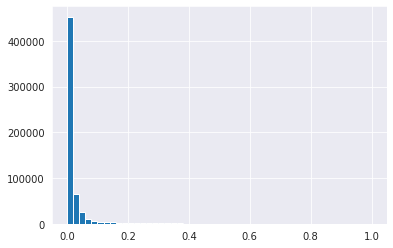

In [22]:
preds_probs = lgbm_model.predict_proba(pred_set)[:,1]
plt.hist(preds_probs, bins=50)
plt.show()

8798


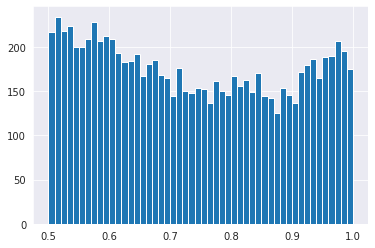

In [23]:
print(len(preds_probs[preds_probs>0.5]))

plt.hist(preds_probs[preds_probs>0.5], bins=50)
plt.show()

#### EDA on predicted results

In [24]:
raw_pred_data["predictions"] = preds

raw_pred_data["predicted_class"] = np.where(raw_pred_data["predictions"]==1, 'Subs', 'Non-Subs')

raw_pred_data.predictions.value_counts()

0    591202
1      8798
Name: predictions, dtype: int64

* Average of (unique pageviews in each sessions)

    * **Same as training** - Avg. pv per session is more for subs

In [25]:
raw_pred_data.groupby('predicted_class')['session_pvs_mean'].describe().T

predicted_class,Non-Subs,Subs
count,591202.00,8798.00
mean,1.01,1.50
std,0.11,1.09
min,1.00,1.00
25%,1.00,1.00
50%,1.00,1.33
75%,1.00,1.81
max,41.00,58.50


* Average and Median of (sum of time on page in each session)

    * **Same as training** - Both avg and median distributions for subscribers are higher than non-subs

In [13]:
raw_pred_data.groupby('predicted_class')['session_top_mean'].describe().T

predicted_class,Non-Subs,Subs
count,591202.00,8798.00
mean,73.67,171.63
std,155.21,226.06
min,0.00,0.00
25%,3.00,46.75
50%,29.17,101.50
75%,79.00,200.00
max,4290.00,3813.00


In [14]:
raw_pred_data.groupby('predicted_class')['session_top_median'].describe().T

predicted_class,Non-Subs,Subs
count,591202.00,8798.00
mean,68.46,146.88
std,153.01,224.89
min,0.00,0.00
25%,0.00,30.00
50%,25.00,74.50
75%,72.00,160.88
max,4290.00,3813.00


In [18]:
def eda(data, columns):
    
    # drop 'other' column
    columns = [x for x in columns if 'other' not in x]
    
    # groupby - calculate sum of pageviews in each category - calculate percentage
    eda_df = data.groupby('predicted_class')[columns].sum().apply(lambda x: (x/x.sum())*100,
                                                                  axis=1).T.sort_values('Subs', ascending=False)
    #rename
    eda_df = eda_df.rename(columns={"Subs": "% of Subs pvs", "Non-Subs": "% of Non-Subs pvs"})

    #calculate rank
    eda_df['Subs_rank'] = eda_df['% of Subs pvs'].rank(ascending=False).astype(int)
    eda_df['NonSubs_rank'] = eda_df['% of Non-Subs pvs'].rank(ascending=False).astype(int)
    
    return eda_df


# make categorical cols
referral_cols =     [col for col in raw_pred_data.columns if 'rf_' in col]
country_cols =      [col for col in raw_pred_data.columns if 'ct_' in col]
deviceos_cols =     [col for col in raw_pred_data.columns if 'dos_' in col]

t1_pv_cols =        [col for col in raw_pred_data.columns if ('t1_' in col) & ('_pvs' in col)]
t2_pv_cols =        [col for col in raw_pred_data.columns if 't2_' in col]
pc_cols =           [col for col in raw_pred_data.columns if 'pc_' in col]
ps_cols =           [col for col in raw_pred_data.columns if 'ps_' in col]

# remove mis-assigned ones
pc_cols.remove('t2_pc_games_pvs')
ps_cols.remove('t1_family_and_relationships_pvs')
ps_cols.remove('t1_family_and_relationships_top')
ps_cols.remove('t2_apprenticeships_pvs')
ps_cols.remove('t2_celebrity_relationships_pvs')

### Pageviews in referral sources, country, device OS

* **Same as training**
    * Subs more from organic search, referral, social, newsletter
    * Non-subs more from content aggregators, direct
    
* **Differs** 
    * Subs % pvs much more in direct

predicted_class,% of Non-Subs pvs,% of Subs pvs,Subs_rank,NonSubs_rank
rf_organic_search,52.64,61.84,1,1
rf_direct,20.50,19.74,2,3
rf_content_aggregators,24.74,7.73,3,2
rf_referral,0.15,6.37,4,5
rf_organic_social_dark,1.88,3.06,5,4
rf_organic_social_forbes,0.04,0.82,6,7
rf_newsletter,0.00,0.35,7,10
rf_paid_search,0.05,0.09,8,6
rf_paid_web,0.00,0.01,9,8
rf_fbia,0.00,0.00,10,9


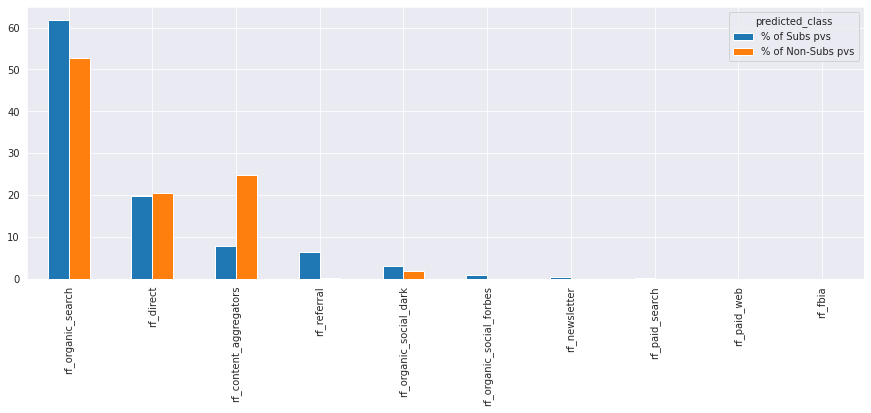

In [17]:
eda(raw_pred_data, referral_cols)[["% of Subs pvs", "% of Non-Subs pvs"]].plot(kind='bar', figsize=(15,5))

eda(raw_pred_data, referral_cols)

* **Same as training**
    * Subs highest in US.
    * Non-subs presence is in other countries also

predicted_class,% of Non-Subs pvs,% of Subs pvs,Subs_rank,NonSubs_rank
ct_united_states,76.79,87.37,1,1
ct_canada,7.83,4.31,2,2
ct_united_kingdom,5.85,2.65,3,3
ct_australia,3.77,1.94,4,4
ct_india,3.41,1.89,5,5
ct_philippines,0.84,0.82,6,7
ct_singapore,0.86,0.66,7,6
ct_germany,0.47,0.24,8,8
ct_russia,0.06,0.06,9,10
ct_japan,0.12,0.05,10,9


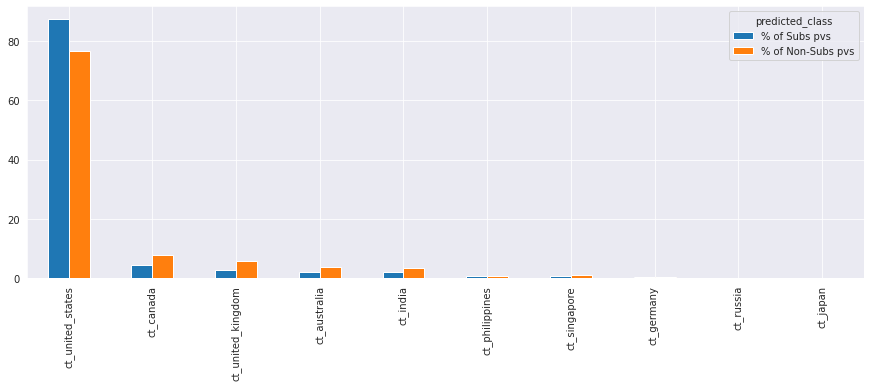

In [18]:
eda(raw_pred_data, country_cols)[["% of Subs pvs", "% of Non-Subs pvs"]].plot(kind='bar', figsize=(15,5))

eda(raw_pred_data, country_cols)

* **Differs** 
    * Predicted subs have far less pvs from desktop compared to phone (fishy)

predicted_class,% of Non-Subs pvs,% of Subs pvs,Subs_rank,NonSubs_rank
dos_android,56.13,61.52,1,1
dos_ios,43.39,37.39,2,2
dos_windows,0.11,0.66,3,4
dos_macintosh,0.37,0.44,4,3


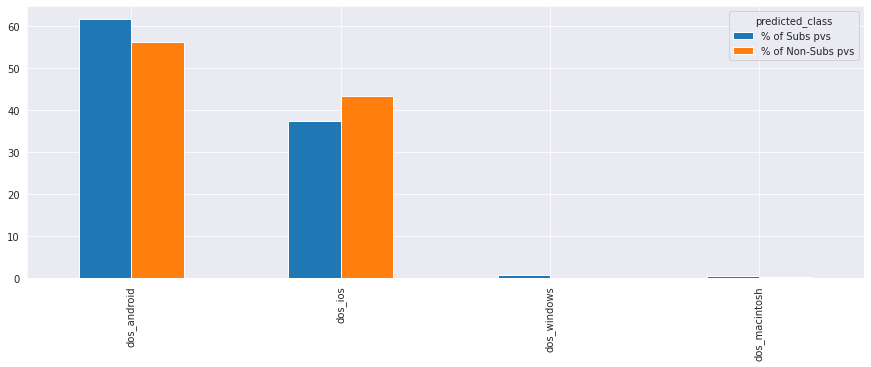

In [19]:
eda(raw_pred_data, deviceos_cols)[["% of Subs pvs", "% of Non-Subs pvs"]].plot(kind='bar', figsize=(15,5))

eda(raw_pred_data, deviceos_cols)

* **Same as training**
    * Mostly all same
    
* **Differs** 
    * Subs have slighlty more pvs in Personal Finance

predicted_class,% of Non-Subs pvs,% of Subs pvs,Subs_rank,NonSubs_rank
t1_business_and_finance_pvs,13.88,25.61,1,3
t1_personal_finance_pvs,16.97,19.23,2,2
t1_technology_and_computing_pvs,19.65,10.39,3,1
t1_news_and_politics_pvs,7.83,8.34,4,4
t1_video_gaming_pvs,7.75,5.98,5,5
t1_medical_health_pvs,7.26,4.19,6,6
t1_sports_pvs,3.33,2.56,7,7
t1_travel_pvs,2.20,2.53,8,11
t1_shopping_pvs,1.79,1.87,9,12
t1_careers_pvs,0.77,1.80,10,18


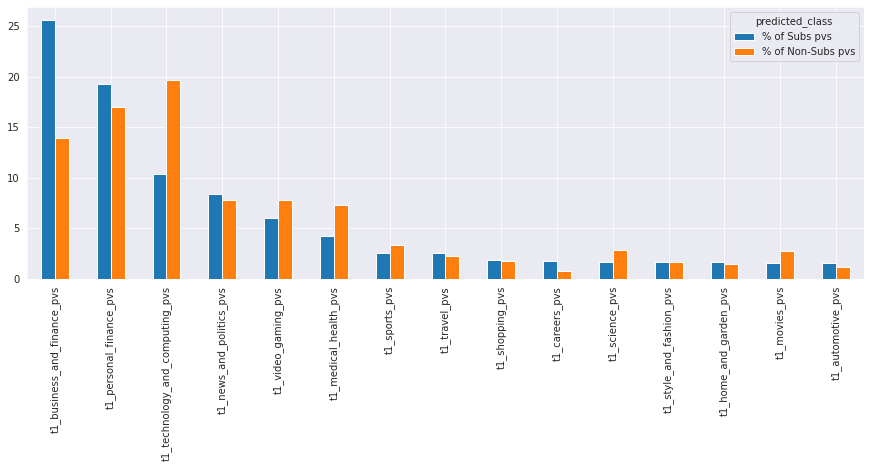

In [20]:
eda(raw_pred_data, t1_pv_cols).head(15)[["% of Subs pvs", "% of Non-Subs pvs"]].plot(kind='bar', figsize=(15,5))

eda(raw_pred_data, t1_pv_cols).head(15)

* **Same as training**
    * Busi, Industries, Personal Investing
    
* **Differs** 
    * Subs have slighlty more pvs in Economy, Games, Personal Debt (fishy)

predicted_class,% of Non-Subs pvs,% of Subs pvs,Subs_rank,NonSubs_rank
t2_economy_pvs,7.66,12.18,1,4
t2_business_pvs,3.85,9.70,2,6
t2_personal_debt_pvs,8.84,8.57,3,2
t2_computing_pvs,12.36,7.03,4,1
t2_personal_investing_pvs,4.18,6.82,5,5
t2_industries_pvs,3.27,5.14,6,9
t2_politics_pvs,3.82,3.98,7,7
t2_pc_games_pvs,3.33,3.45,8,8
t2_consumer_electronics_pvs,8.30,3.32,9,3
t2_law_pvs,2.54,2.28,10,14


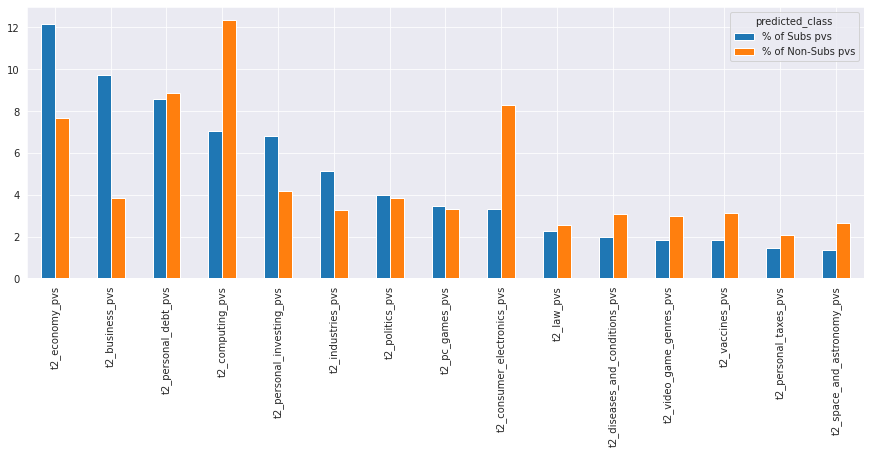

In [21]:
eda(raw_pred_data, t2_pv_cols).head(15)[["% of Subs pvs", "% of Non-Subs pvs"]].plot(kind='bar', figsize=(15,5))

eda(raw_pred_data, t2_pv_cols).head(15)

* **Same as training**
    * Leadership, small business, billionaires, innovation
    
* **Differs** 
    * Subs slighlty more pvs in Money
    * Non-subs slightly more pvs in Business

predicted_class,% of Non-Subs pvs,% of Subs pvs,Subs_rank,NonSubs_rank
pc_money_pvs,27.59,31.09,1,2
pc_innovation_pvs,38.22,19.63,2,1
pc_business_pvs,20.41,18.23,3,3
pc_leadership_pvs,3.57,12.23,4,5
pc_lifestyle_pvs,6.26,6.65,5,4
pc_billionaires_pvs,1.02,2.98,6,6
pc_home_pvs,0.04,2.91,7,17
pc_small_business_pvs,0.90,2.24,8,7
pc_real_estate_pvs,0.51,0.95,9,9
pc_asia_pvs,0.57,0.90,10,8


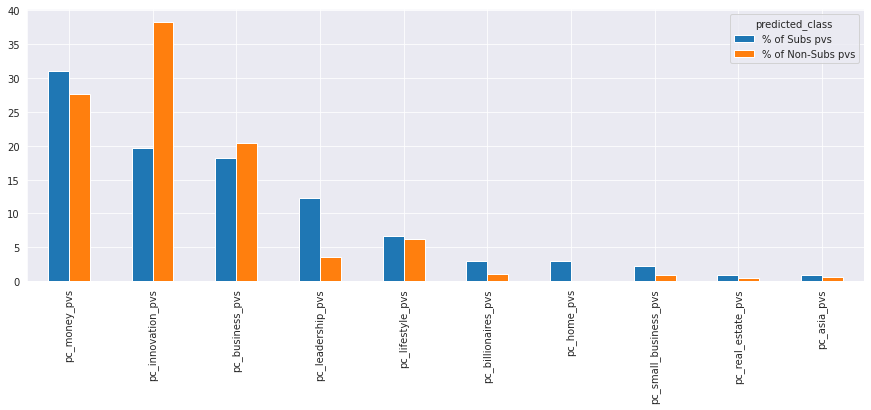

In [22]:
eda(raw_pred_data, pc_cols).head(10)[["% of Subs pvs", "% of Non-Subs pvs"]].plot(kind='bar', figsize=(15,5))

eda(raw_pred_data, pc_cols).head(10)

* **Same as training**
    * Personal Finance, games, tech, leadership strategy, careers, forbes women
    
* **Differs** 
    * Subs slighlty more pvs in crypto

predicted_class,% of Non-Subs pvs,% of Subs pvs,Subs_rank,NonSubs_rank
ps_crypto_and_blockchain_pvs,9.84,16.20,1,4
ps_personal_finance_pvs,14.48,11.95,2,1
ps_games_pvs,12.10,8.02,3,3
ps_consumer_tech_pvs,12.50,6.54,4,2
ps_hollywood_and_entertainment_pvs,4.50,4.95,5,7
ps_leadership_strategy_pvs,0.89,3.39,6,19
ps_careers_pvs,1.07,3.35,7,18
ps_markets_pvs,2.25,3.34,8,12
ps_travel_pvs,2.80,3.26,9,9
ps_investing_pvs,2.21,2.90,10,13


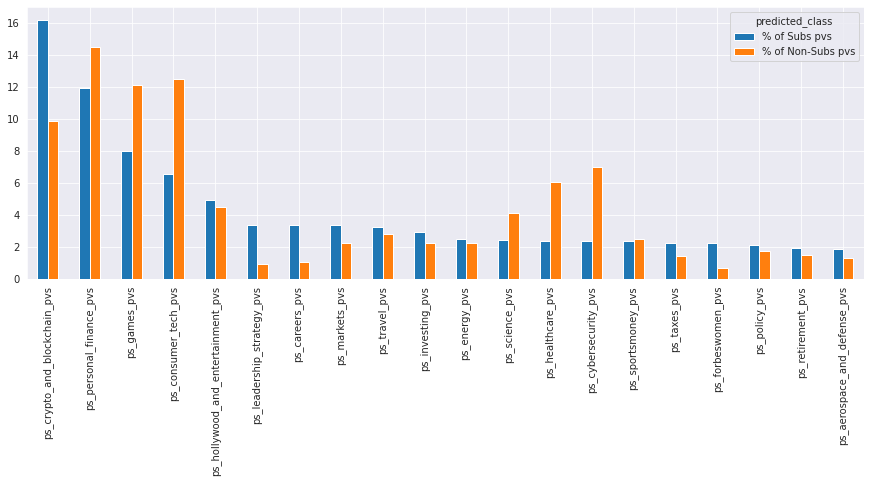

In [31]:
eda(raw_pred_data, ps_cols).head(20)[["% of Subs pvs", "% of Non-Subs pvs"]].plot(kind='bar', figsize=(15,5))

eda(raw_pred_data, ps_cols).head(20)

* **Same as training** - Non-Subs more

In [32]:
raw_pred_data.groupby('predicted_class')['bounce_rate'].describe().T

predicted_class,Non-Subs,Subs
count,591202.00,8798.00
mean,0.99,0.64
std,0.09,0.37
min,0.00,0.00
25%,1.00,0.50
50%,1.00,0.75
75%,1.00,1.00
max,1.00,1.00


* **Same as training** - Non-Subs more

In [33]:
raw_pred_data.groupby('predicted_class')['content_views_rate'].describe().T

predicted_class,Non-Subs,Subs
count,591202.00,8798.00
mean,1.00,0.86
std,0.03,0.22
min,0.00,0.02
25%,1.00,0.75
50%,1.00,1.00
75%,1.00,1.00
max,1.00,1.00
